* Train a boosted ensemble of decision-trees (gradient boosted trees) on the lending club dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Evaluate the trained model and compare it with a baseline.
* Find the most positive and negative loans using the learned model.
* Explore how the number of trees influences classification performance.

In [1]:
import numpy as np
import pandas as pd

In [2]:
loans = pd.read_csv('lending-club-data.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#loans.columns.values
print(loans.shape)
loans.head(1)

(122607, 68)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.1435,20141201T000000,1,1,1


## Modifying the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

In [4]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : 1 if x==0 else -1)

In [5]:
loans = loans.drop(['bad_loans'], axis = 1)

In [6]:
## Selecting features
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

## Skipping observations with missing values

Recall from the lectures that one common approach to coping with missing values is to **skip** observations that contain missing values.

In [7]:
loans.isnull().any().any()

True

In [8]:
loans= loans[[target] + features]

#dataset[[1,2,3,4,5]] = dataset[[1,2,3,4,5]].replace(0, numpy.NaN)

# drop rows with missing values
loans.dropna(inplace=True)

In [9]:
loans.shape

(122578, 25)

## Split data into training and validation sets

In [11]:
import json

with open('train-idx.json', 'r') as f:
    train_idx = json.load(f)
    
with open('validation-idx.json', 'r') as f:
    validation_idx = json.load(f)

## One-hot encoding

In [70]:
def encoding_binary_feature(data, y_label):
    labels =  data.select_dtypes(include=[object])
    encoded_features =[]
    #encoded_values = np.transpose(np.array(np.ones(len(data),)))
    encoded_values = pd.DataFrame(data[y_label])   
    
    for label in labels:
        
        distinct_features = list(set(data[label].values))
    
        for feature in distinct_features:
            encoded_features.append(str(label + '.'+feature))
            
            #new_array = np.array(np.ones(len(data),))
            encoded_values[encoded_features[-1]] = data[label].apply(lambda x : +1 if x==feature else 0)
            
    # labels don't need encoding. we just add those 
    labels = data.select_dtypes(exclude=[object])
    for label in labels: 
        encoded_features.append(str(label))
        encoded_values[encoded_features[-1]] = data[label]
    
    return encoded_values

In [71]:
loans_data = encoding_binary_feature(loans,'safe_loans')
print(loans_data.columns.values)

['safe_loans' 'grade.A' 'grade.E' 'grade.B' 'grade.C' 'grade.D' 'grade.G'
 'grade.F' 'home_ownership.OWN' 'home_ownership.RENT'
 'home_ownership.MORTGAGE' 'home_ownership.OTHER' 'purpose.major_purchase'
 'purpose.car' 'purpose.credit_card' 'purpose.house'
 'purpose.home_improvement' 'purpose.small_business' 'purpose.wedding'
 'purpose.medical' 'purpose.vacation' 'purpose.moving'
 'purpose.debt_consolidation' 'purpose.other' 'sub_grade_num' 'short_emp'
 'emp_length_num' 'dti' 'payment_inc_ratio' 'delinq_2yrs'
 'delinq_2yrs_zero' 'inq_last_6mths' 'last_delinq_none'
 'last_major_derog_none' 'open_acc' 'pub_rec' 'pub_rec_zero' 'revol_util'
 'total_rec_late_fee' 'int_rate' 'total_rec_int' 'annual_inc' 'funded_amnt'
 'funded_amnt_inv' 'installment']


## Train_test split

In [72]:
train_data = loans_data.iloc[train_idx].drop(['safe_loans'], axis = 1)

#train_data = loans_data[features].to_numpy()
train_Y = loans_data['safe_loans'].iloc[train_idx]

test_data = loans_data.iloc[validation_idx].drop(['safe_loans'], axis = 1)
test_Y = loans_data['safe_loans'].iloc[validation_idx]

In [73]:
from sklearn import ensemble 
regressor = ensemble.GradientBoostingClassifier(n_estimators = 5, max_depth = 6)
regressor.fit(train_data, train_Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

## Predictions 


In [74]:
predictions = regressor.predict(test_data)

In [27]:
def accuracy(predictions, output):
    accuracy = (predictions == output).sum()/len(output)
    return accuracy
             

In [75]:
print("validation accuracy: ", accuracy( regressor.predict(test_data), test_Y))

validation accuracy:  0.661460577337


In [76]:
print("Training accuracy: ", accuracy( regressor.predict(train_data), train_Y))

Training accuracy:  0.665493430775


## Sample validation data

In [34]:
test_data.head(2)

,grade.A,grade.E,grade.B,grade.C,grade.D,grade.G,grade.F,home_ownership.OWN,home_ownership.RENT,home_ownership.MORTGAGE,...,purpose.credit_card,purpose.house,purpose.home_improvement,purpose.small_business,purpose.wedding,purpose.medical,purpose.vacation,purpose.moving,purpose.debt_consolidation,purpose.other
24,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
41,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [77]:
validation_safe_loans = test_data[test_Y == 1]
Y_valid_safe_loans = test_Y[test_Y ==1]
validation_risky_loans = test_data[test_Y == -1]
Y_valid_risky_loans = test_Y[test_Y ==-1]
sample_validation_data_risky = validation_risky_loans[0:2]
Y_sample_valid_safe =  Y_valid_safe_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]
Y_sample_valid_risky = Y_valid_risky_loans[0:2]
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
Y_sample_valid_data = Y_sample_valid_safe.append(Y_sample_valid_risky)
sample_validation_data

,grade.A,grade.E,grade.B,grade.C,grade.D,grade.G,grade.F,home_ownership.OWN,home_ownership.RENT,home_ownership.MORTGAGE,...,pub_rec,pub_rec_zero,revol_util,total_rec_late_fee,int_rate,total_rec_int,annual_inc,funded_amnt,funded_amnt_inv,installment
22,0,0,1,0,0,0,0,0,0,1,...,0.0,1.0,93.9,0.0,9.91,823.48,92000.0,15000,15000,483.38
26,0,0,1,0,0,0,0,0,1,0,...,0.0,1.0,59.1,0.0,11.71,1622.21,25000.0,8500,8500,281.15
24,0,0,0,0,1,0,0,0,1,0,...,0.0,1.0,59.5,0.0,16.77,719.11,50004.0,5000,5000,123.65
41,1,0,0,0,0,0,0,0,0,1,...,0.0,1.0,62.1,0.0,8.90,696.99,100000.0,5000,5000,158.77


In [78]:
predictions_sample = regressor.predict(sample_validation_data)

In [79]:
predictions_sample

array([ 1,  1, -1,  1], dtype=int64)

In [80]:
Y_sample_valid_data

22    1
26    1
24   -1
41   -1
Name: safe_loans, dtype: int64

## Prediction Probabilities

In [118]:
print(regressor.predict_proba(sample_validation_data))

[[ 0.41642331  0.58357669]
 [ 0.46949689  0.53050311]
 [ 0.53807792  0.46192208]
 [ 0.39591639  0.60408361]]


In [82]:
# accuracy can be found using score()

regressor.score(test_data, test_Y)

0.66146057733735464

In [83]:
regressor.score(train_data, train_Y)

0.66549343077460432

## Let us assume that each mistake costs money:
* Assume a cost of ```$10,000``` per false negative.

* Assume a cost of ```$20,000``` per false positive.

What is the total cost of mistakes made by decicion model

In [87]:
valid_prediction = regressor.predict(test_data)

false_positive= ((valid_prediction != test_Y) & (valid_prediction==1)).sum()
false_negative= ((valid_prediction != test_Y) & (valid_prediction==-1)).sum()
print(false_negative * 10000 + false_positive*20000)

47950000


In [88]:
print(false_positive)
print(false_negative)

1652
1491


## Most positive & negative loans

In [91]:
prediction_prob_loans = regressor.predict_proba(test_data)
print(prediction_prob_loans.shape)

(9284, 2)


In [92]:
prediction_prob_loans[0:2,:]

array([[ 0.53807792,  0.46192208],
       [ 0.39591639,  0.60408361]])

In [93]:
predictions_model5 = pd.DataFrame(prediction_prob_loans)
predictions_model5.columns = ['risky','safe']

In [97]:
predictions_model5 = predictions_model5.sort_values(by = 'safe')
top5_negative = predictions_model5.iloc[0:5]
top5_positive = predictions_model5.iloc[-5:]
print(top5_negative)
print(top5_positive)

         risky      safe
2028  0.692666  0.307334
3217  0.692666  0.307334
876   0.687194  0.312806
4085  0.684031  0.315969
4408  0.684031  0.315969
         risky      safe
5009  0.338532  0.661468
7094  0.338532  0.661468
6905  0.338532  0.661468
5104  0.338532  0.661468
278   0.326941  0.673059


In [116]:
test_data_raw = loans_data.iloc[validation_idx].drop(['safe_loans'], axis = 1)
test_data_raw.iloc[7094  ]

grade.A                           1.00000
grade.E                           0.00000
grade.B                           0.00000
grade.C                           0.00000
grade.D                           0.00000
grade.G                           0.00000
grade.F                           0.00000
home_ownership.OWN                0.00000
home_ownership.RENT               1.00000
home_ownership.MORTGAGE           0.00000
home_ownership.OTHER              0.00000
purpose.major_purchase            0.00000
purpose.car                       0.00000
purpose.credit_card               0.00000
purpose.house                     0.00000
purpose.home_improvement          0.00000
purpose.small_business            0.00000
purpose.wedding                   0.00000
purpose.medical                   0.00000
purpose.vacation                  0.00000
purpose.moving                    0.00000
purpose.debt_consolidation        1.00000
purpose.other                     0.00000
sub_grade_num                     

## Comparison with decision trees

In [101]:
model_10 = ensemble.GradientBoostingClassifier(n_estimators =10, max_depth = 6)
model_10.fit(train_data, train_Y)
train_error_10 = 1 - model_10.score(train_data, train_Y)

In [102]:
train_error_10

0.32832692979392242

In [103]:
model_50 = ensemble.GradientBoostingClassifier(n_estimators =50, max_depth = 6)
model_50.fit(train_data, train_Y)
train_error_50 = 1 - model_50.score(train_data, train_Y)
print(train_error_50)

0.283672317902


In [104]:
model_100 = ensemble.GradientBoostingClassifier(n_estimators =100, max_depth = 6)
model_100.fit(train_data, train_Y)
train_error_100 = 1 - model_100.score(train_data, train_Y)
print(train_error_100)

0.253633896666


In [106]:
model_200 = ensemble.GradientBoostingClassifier(n_estimators =200, max_depth = 6)
model_200.fit(train_data, train_Y)
train_error_200 = 1 - model_200.score(train_data, train_Y)
print(train_error_200)

0.214970848223


In [107]:
model_500 = ensemble.GradientBoostingClassifier(n_estimators =500, max_depth = 6)
model_500.fit(train_data, train_Y)
train_error_500 = 1 - model_500.score(train_data, train_Y)
print(train_error_500)

0.131680055885


In [108]:
validation_err_10 = 1 - model_10.score(test_data, test_Y)
validation_err_50 = 1 - model_50.score(test_data, test_Y)
validation_err_100 = 1 - model_100.score(test_data, test_Y)
validation_err_200 = 1 - model_200.score(test_data, test_Y)
validation_err_500 = 1 - model_500.score(test_data, test_Y)

In [117]:
print(validation_err_10)
print(validation_err_50)
print(validation_err_100)
print(validation_err_200)
print(validation_err_500)

0.333692373977
0.316242998707
0.310965101249
0.310857389056
0.309026281775


In [110]:
training_errors = [train_error_10, train_error_50, train_error_100, train_error_200, train_error_500]
validation_errors = [validation_err_10, validation_err_50, validation_err_100, validation_err_200, validation_err_500]

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

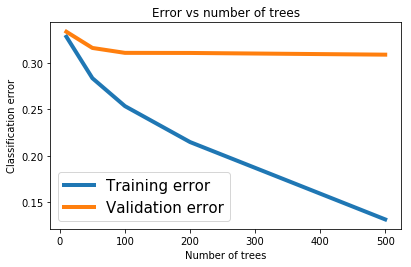

In [112]:
# plot training_errors and validation errors
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')